# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

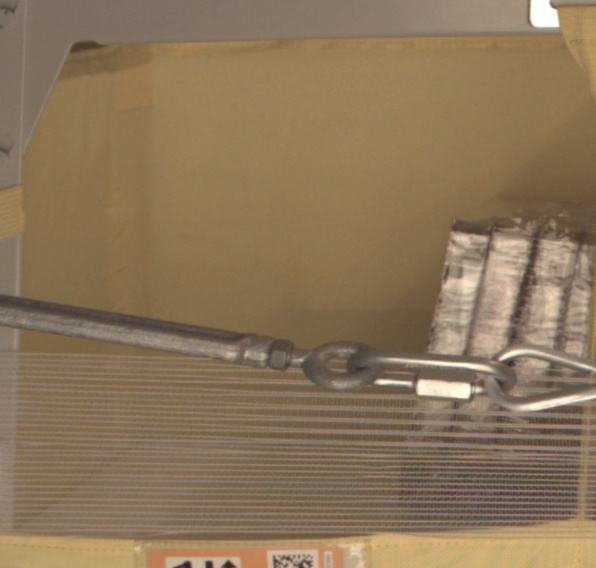

In [2]:
from PIL import Image
import io
Image.open('./binImages/test/1/00009.jpg')

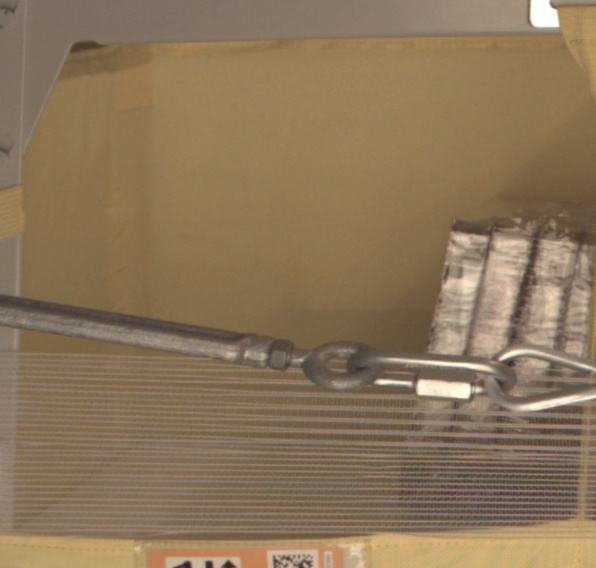

In [3]:
with open("./binImages/test/1/00009.jpg", "rb") as image:
  f = image.read()

Image.open(io.BytesIO(f))

In [4]:
# TODO: Install any packages that you might need
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 568.1 kB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 77.0 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
# TODO: Import any packages that you might need
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
#    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from sagemaker.pytorch import PyTorch

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:33<00:00, 13.11it/s]


100%|██████████| 2299/2299 [03:00<00:00, 12.73it/s]


100%|██████████| 2666/2666 [03:26<00:00, 12.94it/s]


100%|██████████| 2373/2373 [03:06<00:00, 12.75it/s]


100%|██████████| 1875/1875 [02:26<00:00, 12.78it/s]


In [20]:
# Distribution of images for proposal
import os
for i in range(1,6):
    num_files = sum([len(files) for r, d, files in os.walk("train_data/"+str(i))])
    print("# files of folder {}: {}".format(str(i), num_files))

# files of folder 1: 1228
# files of folder 2: 2299
# files of folder 3: 2666
# files of folder 4: 2373
# files of folder 5: 1875


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

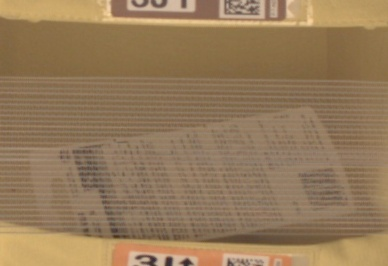

Width: 388, Height: 266


In [4]:
#TODO: Perform any data cleaning or data preprocessing
from PIL import Image
import os, random
directory = './train_data/1/'
image = Image.open(directory + str(random.choice(os.listdir(directory))))
display(image)
width, height = image.size
print('Width: '+str(width)+', Height: '+str(height))

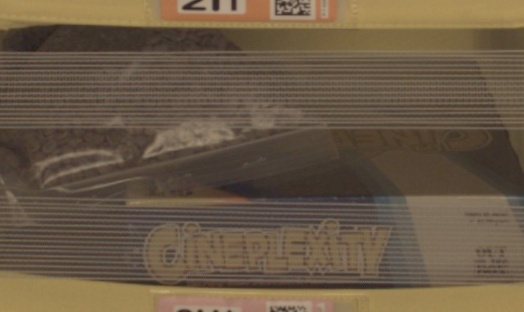

Width: 524, Height: 312


In [5]:
from PIL import Image
import os, random
directory = './train_data/2/'
image = Image.open(directory + str(random.choice(os.listdir(directory))))
display(image)
width, height = image.size
print('Width: '+str(width)+', Height: '+str(height))

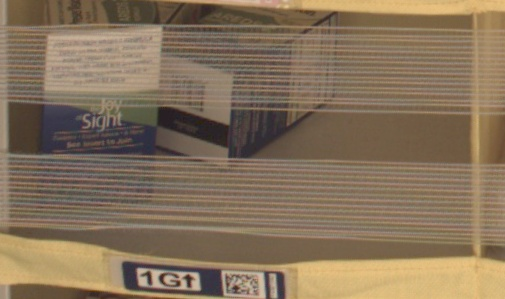

Width: 505, Height: 299


In [6]:
from PIL import Image
import os, random
directory = './train_data/3/'
image = Image.open(directory + str(random.choice(os.listdir(directory))))
display(image)
width, height = image.size
print('Width: '+str(width)+', Height: '+str(height))

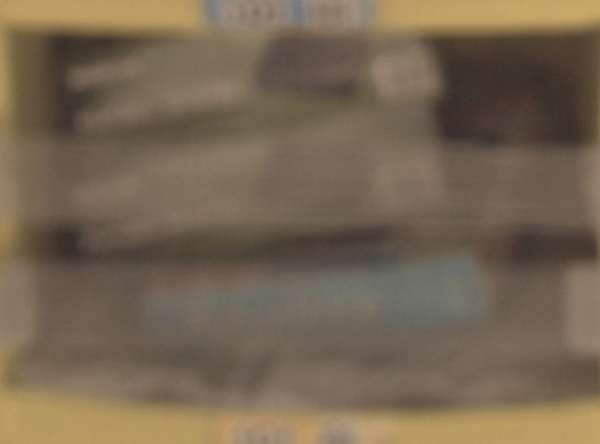

Width: 600, Height: 444


In [7]:
from PIL import Image
import os, random
directory = './train_data/4/'
image = Image.open(directory + str(random.choice(os.listdir(directory))))
display(image)
width, height = image.size
print('Width: '+str(width)+', Height: '+str(height))

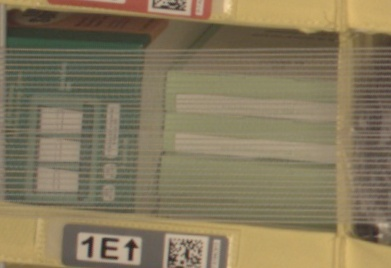

Width: 391, Height: 268


In [8]:
from PIL import Image
import os, random
directory = './train_data/5/'
image = Image.open(directory + str(random.choice(os.listdir(directory))))
display(image)
width, height = image.size
print('Width: '+str(width)+', Height: '+str(height))
#im_resized = image.resize((224, 224))
#display(im_resized)

All images had different sizes => Resizing necessary for model input

In [9]:
# Split into training, validation and test data
# Create folder structure
import os

folders_purpose = ['train', 'valid', 'test']
folders_classes = ['1', '2', '3', '4', '5']

for i in folders_purpose:
    for j in folders_classes:
        dir = os.path.join('.','binImages',i,j)
        if not os.path.exists(dir):
            os.makedirs(dir)

In [10]:
import shutil

src = r"./train_data"
dst = r"./train_data_temp"
shutil.copytree(src, dst)

'./train_data_temp'

In [23]:
# Copy data from tran_data to the correct folders in binImages

import shutil, random, os

src = 'train_data_temp'

# Moving train data (70%)
dst = 'binImages/train'
for i in range(1,6):
    num_files = int(sum([len(files) for r, d, files in os.walk(src+'/'+str(i))]) * 0.7)
    filenames = random.sample(os.listdir(os.path.join(src,str(i))), num_files)
    for fname in filenames:
        srcpath = os.path.join(src, str(i), fname)
        shutil.move(os.path.abspath(srcpath),os.path.abspath(os.path.join(dst,str(i),fname)))
        
# Moving validation data (20%)
dst = 'binImages/valid'
for i in range(1,6):
    num_files = int(sum([len(files) for r, d, files in os.walk(src+'/'+str(i))]) * 0.67)
    filenames = random.sample(os.listdir(os.path.join(src,str(i))), num_files)
    for fname in filenames:
        srcpath = os.path.join(src, str(i), fname)
        shutil.move(os.path.abspath(srcpath), os.path.abspath(os.path.join(dst,str(i),fname)))
        
# Moving test data (10%)
dst = 'binImages/test'
for i in range(1,6):
    filenames = [f for f in os.listdir(os.path.join(src,str(i)))]
    for fname in filenames:
        srcpath = os.path.join(src, str(i), fname)
        shutil.move(os.path.abspath(srcpath), os.path.abspath(os.path.join(dst,str(i),fname)))

In [24]:
# Check if copying worked well
import os
print('Train:')
for i in range(1,6):
    num_files = sum([len(files) for r, d, files in os.walk("binImages/train/"+str(i))])
    print("# files of folder {}: {}".format(str(i), num_files))
print('Valid:')
for i in range(1,6):
    num_files = sum([len(files) for r, d, files in os.walk("binImages/valid/"+str(i))])
    print("# files of folder {}: {}".format(str(i), num_files))
print('Test:')
for i in range(1,6):
    num_files = sum([len(files) for r, d, files in os.walk("binImages/test/"+str(i))])
    print("# files of folder {}: {}".format(str(i), num_files))

Train:
# files of folder 1: 859
# files of folder 2: 1609
# files of folder 3: 1866
# files of folder 4: 1661
# files of folder 5: 1312
Valid:
# files of folder 1: 247
# files of folder 2: 462
# files of folder 3: 536
# files of folder 4: 477
# files of folder 5: 377
Test:
# files of folder 1: 122
# files of folder 2: 228
# files of folder 3: 264
# files of folder 4: 235
# files of folder 5: 186


In [25]:
#Remove temporary train_data folder
dir_path = r"./train_data_temp"
shutil.rmtree(dir_path, ignore_errors=True)

In [2]:
#TODO: Upload the data to AWS S3
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "capstone/binImages"
local_dir = 'binImages'

inputs = sagemaker_session.upload_data(path=local_dir, bucket=bucket, key_prefix=prefix)

In [ ]:
# Declaring inputs for new kernel sessions
inputs = 's3://sagemaker-us-east-1-751018309271/capstone/binImages'

In [6]:
import boto3
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3_client = boto3.resource('s3')
s3_bucket = s3_client.Bucket(bucket)
count_obj = sum(1 for _ in s3_bucket.objects.all())
print(count_obj)

10441


Number of s3 objects matches with the original dataset. Upload was successful!

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [ ]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {
    "lr": 0.01,
    "epochs": 2,
    "batch_size": 256
}

In [ ]:
# Standout Suggestion: Debugging

from sagemaker.debugger import Rule, DebuggerHookConfig, CollectionConfig, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
]

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0", parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "100","eval.save_interval": "10"})]

debugger_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

In [ ]:
#TODO: Create your training estimator
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    #instance_type="ml.g4dn.2xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [ ]:
# TODO: Fit your estimator
estimator.fit({"training": inputs})

2022-07-27 20:27:42 Starting - Starting the training job...
2022-07-27 20:28:04 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport-1658953662: InProgress
......
2022-07-27 20:29:14 Downloading - Downloading input data..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-27 20:31:25,114 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-27 20:31:25,117 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-07-27 20:31:25,125 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-27 20:31:25,133 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-27 20:31:25,682 sagemaker-training-toolkit INFO     No GPUs 

In [19]:
# load estimator when kernel died

estimator = sagemaker.estimator.Estimator.attach('pytorch-training-2022-07-27-20-27-42-596')
model_location=estimator.model_data


2022-07-27 21:34:00 Starting - Preparing the instances for training
2022-07-27 21:34:00 Downloading - Downloading input data
2022-07-27 21:34:00 Training - Training image download completed. Training in progress.
2022-07-27 21:34:00 Uploading - Uploading generated training model
2022-07-27 21:34:00 Completed - Training job completed


In [22]:
# create predictor
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

pytorch_model = PyTorchModel(model_data=model_location, 
                             role=sagemaker.get_execution_role(), 
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.4')
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-----!

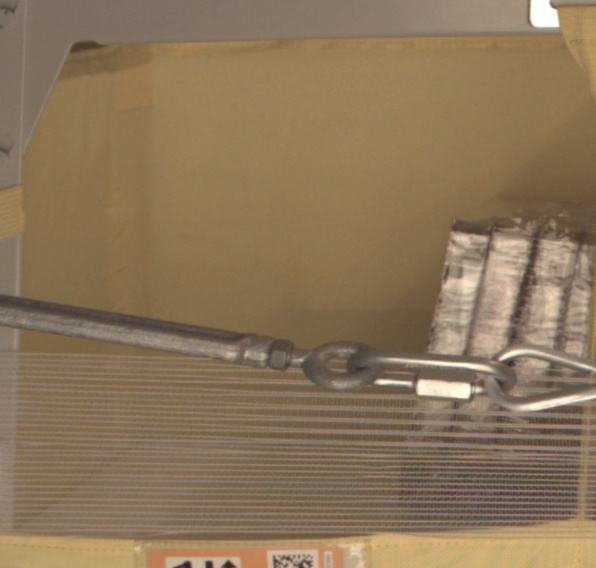

In [11]:
with open("./binImages/test/1/00009.jpg", "rb") as image:
  img = image.read()

Image.open(io.BytesIO(img))

In [13]:
type(img)

bytes

In [23]:
response=predictor.predict(img, initial_args={"ContentType": "image/jpeg"})

InternalFailure: An error occurred (InternalFailure) when calling the InvokeEndpoint operation (reached max retries: 4): An exception occurred while sending request to model. Please contact customer support regarding request 1fd8efd6-32dc-4dd0-bd3e-371a47b971a6.

In [15]:
model_location

's3://sagemaker-us-east-1-751018309271/pytorch-training-2022-07-27-20-27-42-596/output/model.tar.gz'

In [ ]:
# Todo:
# multiinstance & time measurement
# predictor (loop)
# batch transform
# inference script (model adaption)
# training plot
# accuracy ablesen
# hpo

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances